In [19]:
# calculate residual errors for a persistence forecast model
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

import pickle, time, os, sys, re, random

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

from statsmodels.distributions.copula.api import CopulaDistribution, StudentTCopula
try:
    from scipy import stats
except:
    %pip install scipy -U
    from scipy import stats
    
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

In [2]:
import statsmodels
statsmodels.__version__

'0.14.0'

In [232]:
m_r = pd.read_csv("Monthly_Returns.csv")

In [234]:
m_r = m_r.iloc[:,:6]

In [466]:
print(m_r.shape)
m_r.head()

(1200, 6)


,Month_year,Stock_Total,Dividend,Bond_Total,Bond_Income,Inflation
0,1926-01-31,0.000000,0.001567,0.013756,0.003111,0.000000
1,1926-02-28,-0.038462,0.005494,0.006313,0.002848,0.000000
2,1926-03-31,-0.057471,0.001642,0.004129,0.003234,-0.005587
3,1926-04-30,0.025305,0.002617,0.007589,0.002997,0.005618
4,1926-05-31,0.017918,0.010239,0.001412,0.002800,-0.005587


In [236]:
m_r.iloc[:,range(1, 6)].mean(axis = 0)

Stock_Total    0.009557
Dividend       0.003140
Bond_Total     0.004547
Bond_Income    0.004072
Inflation      0.002440
dtype: float64

# get subset of m_r after 1972

In [237]:
m_r['Month_year'] = pd.to_datetime(m_r.Month_year)

In [238]:
m_r_sub = m_r[m_r.Month_year > "1971-11-30"]
m_r_sub.head()

,Month_year,Stock_Total,Dividend,Bond_Total,Bond_Income,Inflation
551,1971-12-31,0.088839,0.004149,0.004421,0.005002,0.004890
552,1972-01-31,0.020570,0.001051,-0.006350,0.005006,0.000000
553,1972-02-29,0.027708,0.002405,0.008805,0.004693,0.004866
554,1972-03-31,0.008260,0.002348,-0.008180,0.004890,0.002421
555,1972-04-30,0.006807,0.002423,0.002712,0.004809,0.002416


In [239]:
m_r_sub.shape

(617, 6)

In [240]:
#one quarter before year 1972 inclusing last month of 1971
m_r_sub[['Stock_Total','Dividend','Bond_Total','Bond_Income','Inflation']].mean(axis = 0)

Stock_Total    0.009554
Dividend       0.002396
Bond_Total     0.006302
Bond_Income    0.005226
Inflation      0.003260
dtype: float64

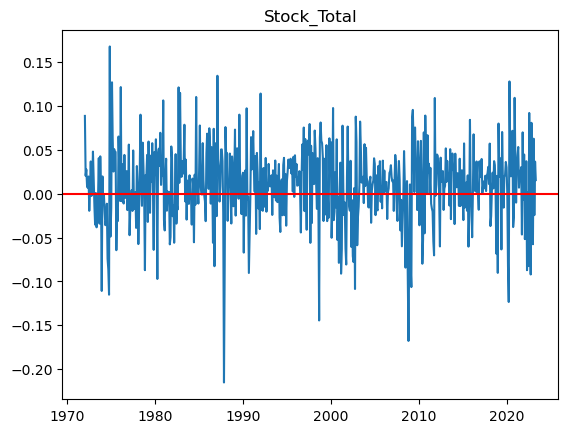

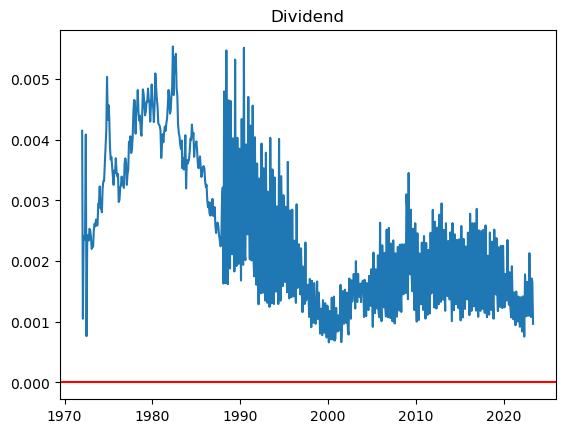

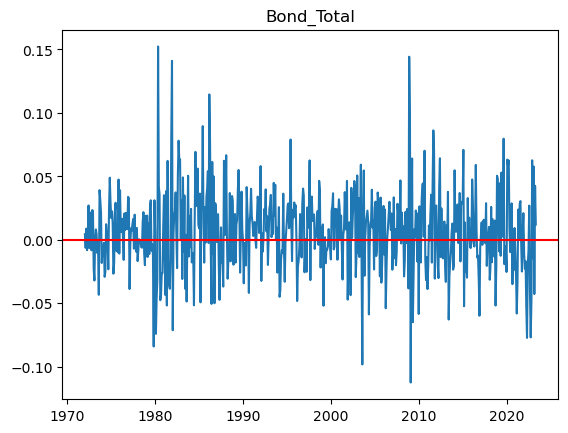

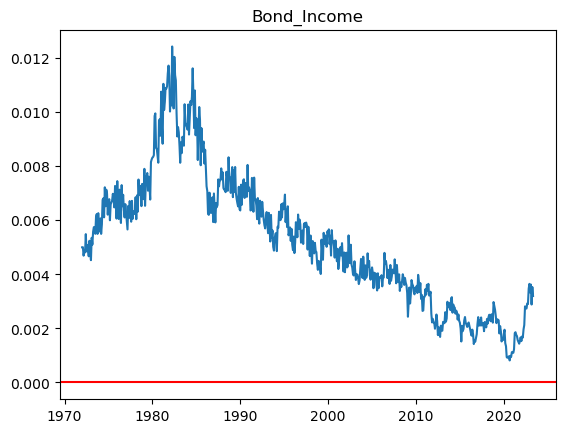

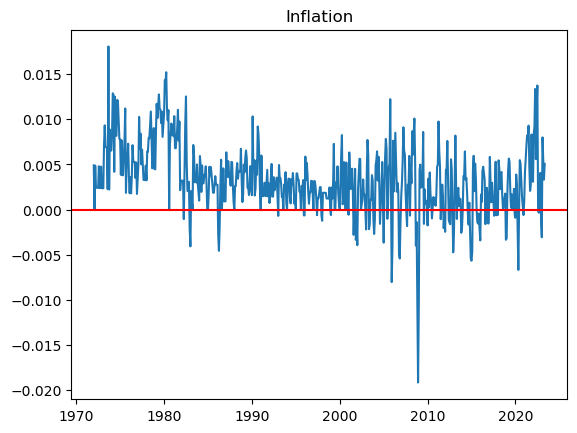

In [241]:
for i in m_r_sub.columns[1:]:
    # plt.plot(m_r[i].diff().dropna())
    # plt.axhline(y = 0, color = "r")
    # plt.title(f"{i} w/ Difference(1)") 
    plt.plot(m_r_sub.Month_year, m_r_sub[i])
    plt.axhline(y = 0, color = "r")
    plt.title(f"{i}")   
    plt.show()

# Test stationarity and autocorrelationof Rates

In [242]:
def adf_test(series):
    #print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    # for key,value in dftest[4].items():
    #     dfoutput['Critical Value (%s)'%key] = value
    if dftest[1] >0.05:
        print (f"{series.name} is not stationary")
    else:
        print (f"{series.name} is stationary")

In [243]:
for i in m_r_sub.columns[1:]:
    adf_test(m_r_sub.loc[:,i])

Stock_Total is stationary
Dividend is not stationary
Bond_Total is stationary
Bond_Income is not stationary
Inflation is stationary


In [244]:
from statsmodels.stats.stattools import durbin_watson

In [245]:
for i in m_r_sub.columns[1:]:
    ''' check is the DW test return a value between 1.5 and 2.5'''
    
    print(i ,  durbin_watson(m_r_sub.loc[:,i]))

Stock_Total 1.912408471942867
Dividend 0.12179919857210987
Bond_Total 1.7927473214493628
Bond_Income 0.009102052956493023
Inflation 0.4590149381754221


# Fit lienar regression with yt vs yt-1

# get lag of y as y_lag

In [254]:
for i in ['Dividend','Bond_Income', 'Inflation']:
    # if i == 'Dividend':
    #     m_r_sub[f"{i}_lag"] = m_r_sub[i].shift(2)
    # else:
    m_r_sub[f"{i}_lag"] = m_r_sub[i].shift()

In [255]:
m_r_sub.dropna(inplace = True)
m_r_sub.head()

,Month_year,Stock_Total,Dividend,Bond_Total,Bond_Income,Inflation,Dividend_lag,Bond_Income_lag,Inflation_lag
552,1972-01-31,0.020570,0.001051,-0.006350,0.005006,0.000000,0.004149,0.005002,0.004890
553,1972-02-29,0.027708,0.002405,0.008805,0.004693,0.004866,0.001051,0.005006,0.000000
554,1972-03-31,0.008260,0.002348,-0.008180,0.004890,0.002421,0.002405,0.004693,0.004866
555,1972-04-30,0.006807,0.002423,0.002712,0.004809,0.002416,0.002348,0.004890,0.002421
556,1972-05-31,0.019690,0.004087,0.027037,0.005489,0.002410,0.002423,0.004809,0.002416


In [467]:
m_r_sub.shape

(616, 9)

In [156]:
# m_r_sub = m_r_sub[m_r_sub.Month_year >= "1987-10-31"]
# plt.plot(m_r_sub.Month_year, m_r_sub.Dividend)

In [258]:
pickle.dump(m_r_sub, open("m_r_sub.pkl", "wb"))

In [24]:
m_r_sub = pickle.load(open("m_r_sub.pkl", "rb"))

In [25]:
m_r_sub.iloc[:,[1,2,3,4,5]].mean(axis=0)

Stock_Total    0.009425
Dividend       0.002393
Bond_Total     0.006305
Bond_Income    0.005226
Inflation      0.003258
dtype: float64

In [261]:
#get correlation coeff of 5 rates
m_r_sub.iloc[:,[1,2,3,4,5]].corr()

,Stock_Total,Dividend,Bond_Total,Bond_Income,Inflation
Stock_Total,1.000000,0.073941,0.093311,0.012786,-0.075839
Dividend,0.073941,1.000000,0.091891,0.711169,0.315100
Bond_Total,0.093311,0.091891,1.000000,0.124601,-0.181535
Bond_Income,0.012786,0.711169,0.124601,1.000000,0.301324
Inflation,-0.075839,0.315100,-0.181535,0.301324,1.000000


# fit individual Student t-distribution w/ and w/o fixed mean

In [262]:
stats.t.fit(m_r_sub['Stock_Total']) #df, mu, sigma

(5.683821560578799, 0.011030312789682282, 0.036000871052010164)

In [263]:
stats.t.fit(m_r_sub['Stock_Total'], floc= m_r_sub['Stock_Total'].mean()) #df, mu, sigma

(5.873124027006535, 0.009425142857142856, 0.03624716233825319)

# simulate non-negative dividend - given unual data before 1987, only after year 2000 will be use to fit t-dist  

In [264]:
#m_r_sub = m_r_sub[m_r_sub.Month_year >= "2000"]

In [372]:
m_r_sub.head()

,Month_year,Stock_Total,Dividend,Bond_Total,Bond_Income,Inflation,Dividend_lag,Bond_Income_lag,Inflation_lag
552,1972-01-31,0.020570,0.001051,-0.006350,0.005006,0.000000,0.004149,0.005002,0.004890
553,1972-02-29,0.027708,0.002405,0.008805,0.004693,0.004866,0.001051,0.005006,0.000000
554,1972-03-31,0.008260,0.002348,-0.008180,0.004890,0.002421,0.002405,0.004693,0.004866
555,1972-04-30,0.006807,0.002423,0.002712,0.004809,0.002416,0.002348,0.004890,0.002421
556,1972-05-31,0.019690,0.004087,0.027037,0.005489,0.002410,0.002423,0.004809,0.002416


In [471]:
div_ =  m_r_sub.Dividend
div_lag_ = m_r_sub.Dividend_lag

In [472]:
dividend_fit = LinearRegression().fit(pd.DataFrame(div_lag_), div_)
print(f"intercept: {dividend_fit.intercept_}; coef_: {dividend_fit.coef_}")

intercept: 0.0007256701241657836; coef_: [0.69526018]


In [473]:
dividend_error = div_ - dividend_fit.predict(pd.DataFrame(div_lag_))

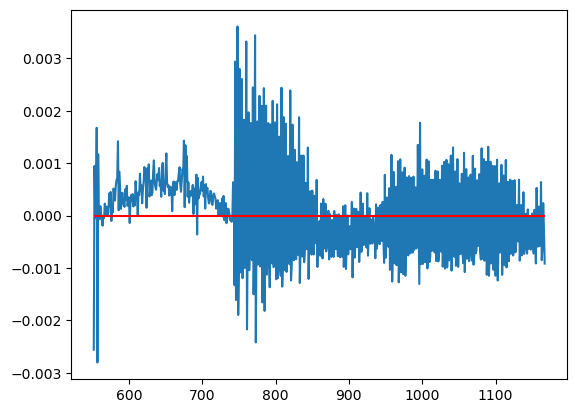

In [474]:
plt.plot(dividend_error)
plt.hlines(y = 0, xmin = dividend_error.index.min(), xmax = dividend_error.index.max(), color = "red")

In [475]:
stats.t.fit(dividend_error) #df, mu, sigma , negative dividends will be capped by zeros

(2.0258140700742486, -0.00010057911197137212, 0.0006374717904275343)

In [476]:
#test symetrix t-distribution on fit dividend LR errors
div_sample = stats.t.rvs(2.0889367664126173, -0.00026840344489644636, 0.0004397197518428823, size=10000)

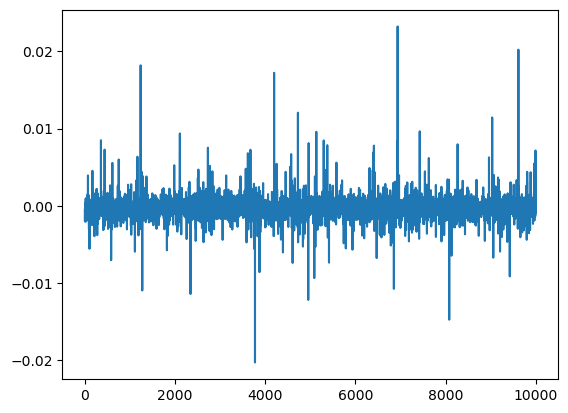

In [277]:
plt.plot(div_sample)

# fit bond income distribution

In [278]:
m_r_sub.columns

Index(['Month_year', 'Stock_Total', 'Dividend', 'Bond_Total', 'Bond_Income',
       'Inflation', 'Dividend_lag', 'Bond_Income_lag', 'Inflation_lag'],
      dtype='object')

In [279]:
income_log = np.log(m_r_sub['Bond_Income'])
income_lag_log = np.log(m_r_sub['Bond_Income_lag'])

In [280]:
income_fit = LinearRegression().fit(pd.DataFrame(income_lag_log), income_log)
print(f"intercept: {income_fit.intercept_}; coef_: {income_fit.coef_}")

intercept: -0.10006691843453908; coef_: [0.98154254]


In [281]:
income_error = income_log - income_fit.predict(pd.DataFrame(income_lag_log))

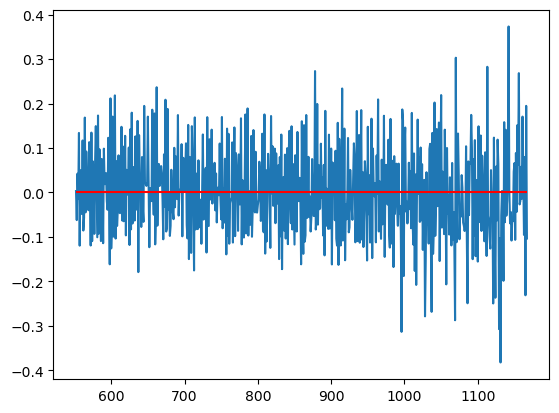

In [282]:
plt.plot(income_error)
plt.hlines(y = 0, xmin = income_error.index.min(), xmax = income_error.index.max(),
           color = "red")

# fit inflation distribution

In [283]:
inflation_fit = LinearRegression().fit(m_r_sub[['Inflation_lag']], m_r_sub.Inflation)
print(f"intercept: {inflation_fit.intercept_}; coef_: {inflation_fit.coef_}")

intercept: 0.0012978017289868183; coef_: [0.60165003]


In [284]:
inflation_error = m_r_sub.Inflation - inflation_fit.predict(m_r_sub[['Inflation_lag']])

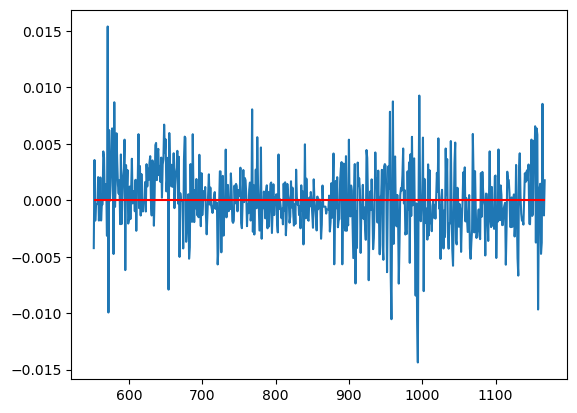

In [285]:
plt.plot(inflation_error)
plt.hlines(y = 0, xmin = inflation_error.index.min(), xmax = inflation_error.index.max(),
           color = "red")

In [286]:
pickle.dump((income_fit, dividend_fit, inflation_fit), open("monthly_fits.pkl", "wb"))

In [21]:
(income_fit, dividend_fit, inflation_fit) = pickle.load(open("monthly_fits.pkl", "rb"))

# simulate Dividend and Bond_Income errors

In [288]:
pickle.dump((income_error, dividend_error, inflation_error), open("monthly_errors.pkl", "wb"))

In [22]:
(income_error, dividend_error, inflation_error) = pickle.load(open("monthly_errors.pkl", "rb"))

# fit t-distribution of 5 rates

In [26]:
error_df = pd.concat([m_r_sub['Stock_Total'], pd.Series(income_error), 
                      pd.Series(dividend_error), pd.Series(inflation_error),
                      m_r_sub['Bond_Total']], axis = 1)                      

In [27]:
error_df.head()

,Stock_Total,Bond_Income,Dividend,Inflation,Bond_Total
552,0.020570,0.003080,-0.002559,-0.004240,-0.006350
553,0.027708,-0.062270,0.000949,0.003568,0.008805
554,0.008260,0.042224,-0.000050,-0.001804,-0.008180
555,0.006807,-0.014840,0.000065,-0.000338,0.002712
556,0.019690,0.133811,0.001677,-0.000341,0.027037


In [28]:
#fit t-distribution with the mean as location for stock and bond returns
stock_para = stats.t.fit(m_r_sub['Stock_Total'], floc= m_r_sub['Stock_Total'].mean())
income_para = stats.t.fit(income_error)
dividend_para = stats.t.fit(dividend_error)
inflation_para = stats.t.fit(inflation_error)
bond_para = stats.t.fit(m_r_sub['Bond_Total'], floc= m_r_sub['Bond_Total'].mean())

In [294]:
stock_para

(5.873124027006535, 0.009425142857142856, 0.03624716233825319)

In [295]:
income_para

(60.62841062883993, -0.00023814260279532006, 0.10242977623808992)

In [296]:
dividend_para

(2.0258140700742486, -0.00010057911197137212, 0.0006374717904275343)

In [297]:
inflation_para

(5.771591590221103, -2.19975402609666e-05, 0.002464314336258537)

In [298]:
bond_para

(6.170114394754815, 0.006304926948051948, 0.02573763953951525)

In [15]:
# for i in [stock_para, income_para, dividend_para, inflation_para, bond_para]:
#     print(i)

In [299]:
#degree of freedom for StudentTCopula()
df = np.mean([stock_para[0], income_para[0], dividend_para[0], inflation_para[0], bond_para[0]])
df

16.093810942179328

In [51]:
monthly_marginal_lst = [stats.t(5.873124027006535, 0.009425142857142856, 0.03624716233825319),
                stats.t(60.62841062883993, -0.00023814260279532006, 0.10242977623808992),
                stats.t(2.0258140700742486, -0.00010057911197137212, 0.0006374717904275343),
                stats.t(5.771591590221103, -2.19975402609666e-05, 0.002464314336258537),
                stats.t(6.170114394754815, 0.006304926948051948, 0.02573763953951525)]      

# optimized df of StudentTCopula

In [29]:
dfs = [stock_para[0], income_para[0], dividend_para[0], inflation_para[0], bond_para[0]]

In [30]:
df_min = round(min(dfs), 2); df_max = round(max(dfs), 2)
print(df_min, df_max)

2.03 60.63


In [32]:
corr_ = np.array(error_df.corr())
corr_

array([[ 1.        , -0.04043087,  0.06576551, -0.06704103,  0.09331133],
       [-0.04043087,  1.        , -0.00154488,  0.07774554,  0.00854801],
       [ 0.06576551, -0.00154488,  1.        , -0.00886491,  0.08334131],
       [-0.06704103,  0.07774554, -0.00886491,  1.        , -0.16934928],
       [ 0.09331133,  0.00854801,  0.08334131, -0.16934928,  1.        ]])

In [33]:
corr_abs_diff = {}
for i in tqdm(np.arange(df_min, 100, 0.5)):
    sc_i = StudentTCopula(corr = corr_, df = i, k_dim=5)
    joint_dist = CopulaDistribution(copula=sc_i, marginals= monthly_marginal_lst) 
    sc_spl_i = joint_dist.rvs(50000, random_state = 1234)
    corr_i = np.array(pd.DataFrame(sc_spl_i).corr())
    corr_abs_diff[i] = abs(corr_[np.triu(np.ones_like(corr_)) == 0] - \
                           corr_i[np.triu(np.ones_like(corr_)) == 0]).sum()             

100%|█████████████████████████████████████████| 196/196 [01:42<00:00,  1.92it/s]


In [34]:
df_min = min(corr_abs_diff, key = corr_abs_diff.get)
df_min #

15.53

In [52]:
monthly_sc = StudentTCopula(corr = np.array(error_df.corr()), df = df_min, k_dim=5)

In [53]:
monthly_joint_dist = CopulaDistribution(copula=monthly_sc, marginals= monthly_marginal_lst) 

## compare correlation of simulated and LR errors 

In [54]:
def getSim(y, ar_model, error, type = "non_log"):
    '''get simulation data from the LR'''    
 
    sim_init = y[y.index.max()]
    sim_out = ar_model.intercept_ + ar_model.coef_[0] * sim_init + error   

    if type == "log":
        sim_out = np.exp(sim_out)
        return sim_out
    else:
        return sim_out        

# test scenarios 2 and 6

In [40]:
#read quarterly RMD
rmd_year = pd.read_csv("RMD.csv")

In [41]:
rmd_year.head()

,Age,RMD
0,62,0.0272
1,63,0.0279
2,64,0.0287
3,65,0.0295
4,66,0.0303


In [42]:
rmd_month = pd.DataFrame(columns = ["Age", "RMD"])
for i in rmd_year.Age:
    df_i = pd.DataFrame({"Age":[i + j for j in np.arange(0.0,0.12,0.01)], 
              "RMD":np.repeat(float(rmd_year.RMD[rmd_year.Age == i]/12), 12)})  
    rmd_month = pd.concat([rmd_month, df_i])

In [43]:
rmd_month.head()

,Age,RMD
0,62.00,0.002267
1,62.01,0.002267
2,62.02,0.002267
3,62.03,0.002267
4,62.04,0.002267


In [44]:
rmd_month['RMD1'] = rmd_month.RMD*1.2

In [56]:
months = rmd_month.loc[(rmd_month.Age >= 65) & (rmd_month.Age <= 100)].Age 

In [45]:
def method_2_monthly(org_amt, rmd_month, start_age, end_age, stock_bond_sim_df, 
                       stock_weight, bond_weight, rmd1 = False):
    
    balance = [] 
    withdrawal = [] 
    org_left = org_amt

    rmd_sub = rmd_month.loc[(rmd_month.Age >= start_age) & (rmd_month.Age <= end_age)]
    rmd_sub.index = list(rmd_sub.Age)

    for i in rmd_sub.Age:
        
        if i == start_age:
            '''withdraw RMD/RMD1 % initial balance at the retirement moment''' 
            if rmd1 == True:
                withdrawal_ = org_left * (rmd_sub.RMD1[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = org_left * (rmd_sub.RMD[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            
            withdrawal.append(withdrawal_)
            
            org_left =  (org_left - withdrawal_)                   
            balance.append(org_left)              

        else:            
            '''for the following quarters, the left balance will grow with total bond and total stock 
            returns before next quarterly withdrawal'''            
            grow_left =  org_left * (1 + bond_weight * stock_bond_sim_df.Bond[i] \
                                   + stock_weight * stock_bond_sim_df.Stock[i])

            if rmd1 == True:
                withdrawal_ = grow_left * rmd_sub.RMD1[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                        + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = grow_left * rmd_sub.RMD[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])              
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ >= grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_)             

    return balance, withdrawal

In [72]:
def method_6_monthly(org_amt, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate = 0.06):
    
    global rmd_month
    
    balance = [] 
    withdrawal = []
    org_left = org_amt
    
    rmd_sub = rmd_month.loc[(rmd_month.Age >= start_age) & (rmd_month.Age <= end_age)]
    rmd_sub.index = list(rmd_sub.Age)

    for i in list(rmd_sub.Age):        
        if i == start_age:
            '''withdraw 6%/12 initial balance at the retirement moment'''  
            withdrawal.append(org_left * withdrawal_rate)
            org_left =  org_left * (1-withdrawal_rate)  
            balance.append(org_left)

        elif i == start_age + 0.01:
            '''apply cumulated inflation rate on the 6%/12 of the first year balance''' 

            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = stock_bond_sim_df.Inflation[i]             
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)     
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 
        else:            
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = (1+ stock_bond_sim_df.Inflation[i]) * (1+cum_inflation) - 1
            
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)  
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 

    return balance, withdrawal

In [62]:
rmd_month.head()

,Age,RMD,RMD1
0,62.00,0.002267,0.00272
1,62.01,0.002267,0.00272
2,62.02,0.002267,0.00272
3,62.03,0.002267,0.00272
4,62.04,0.002267,0.00272


In [81]:
def renameCol(col):    
    return [i.replace(".0", "") if i.endswith(".0") else i for i in col]

In [181]:
def sim_10K_monthly(org_amt, withdrawal_rate, start_age, end_age, 
            output_balance_path, output_withdrawal_path, sim_out = False):
    
    global monthly_joint_dist, m_r_sub, rmd_month
    
    '''1) withdrawal_rate is only for method 6
       2) Two types of rmd are used only for method 2 and 3
    '''
    
    print(f'org_amt = {org_amt}; monthly withdrawal rate = {withdrawal_rate}')
    print(f'Output pickle files are {output_balance_path} and {output_withdrawal_path}.\n')
    
    balance_2_0_1 = {}
    balance_2_0_1_1 = {}
    balance_6_0_1 = {}
    
    withdrawal_2_0_1 = {}
    withdrawal_2_0_1_1 = {}
    withdrawal_6_0_1 = {}    
    
    rmd_sub = rmd_month.loc[(rmd_month.Age >= start_age) & (rmd_month.Age <= end_age)]
    rmd_sub.index = list(rmd_sub.Age)
    
    #output sim_dict for quarterly to annual rates conversion  
    sim_dict = {}

    for i in tqdm(range(10000)):
        
        '''simulate 10K of 141 autocorrelated quarterly data start with the last observed autocorrelaton data point'''
        
        stock_bond_sim_df = pd.DataFrame(monthly_joint_dist.rvs(len(rmd_sub.Age), random_state = i))                
        stock_bond_sim_df.index = list(rmd_sub.Age)
        stock_bond_sim_df.columns = ['Stock', 'Income','Dividend','Inflation','Bond']
        stock_bond_sim_df['Income'] = getSim(np.log(m_r_sub['Bond_Income']), 
                                             income_fit, stock_bond_sim_df.Income, type = "log")
        
        stock_bond_sim_df['Dividend'] = getSim(m_r_sub.Dividend, 
                                             dividend_fit, stock_bond_sim_df.Dividend, type = "non_log")
        
        stock_bond_sim_df['Dividend'] = [i if i > 0  else 0 for i in stock_bond_sim_df.Dividend]
        
        stock_bond_sim_df['Inflation'] = getSim(m_r_sub.Inflation, 
                                            inflation_fit, stock_bond_sim_df.Inflation, type = "non_log")
        
        #print(stock_bond_sim_df)
        sim_dict[i] = stock_bond_sim_df

        balance_2_0_1[i], withdrawal_2_0_1[i] = method_2_monthly(org_amt,rmd_month,
                                        start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight)

        balance_2_0_1_1[i], withdrawal_2_0_1_1[i] = method_2_monthly(org_amt,rmd_month,
                                        start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, rmd1 = True)

        balance_6_0_1[i], withdrawal_6_0_1[i] = method_6_monthly(org_amt,start_age, end_age, 
                                        stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate =withdrawal_rate)

        
    pickle.dump((balance_2_0_1, balance_2_0_1_1, balance_6_0_1),                   
                open(f"{output_balance_path}", "wb")) 
   
    pickle.dump((withdrawal_2_0_1, withdrawal_2_0_1_1, withdrawal_6_0_1),
            open(f"{output_withdrawal_path}", "wb")) 
    
    if sim_out == True:
        return sim_dict

In [199]:
# set original retirmetn account balance, fixed quaterly withdrawl rate, bond/stock investiment ratio 
org_amt = 255200
monthly_withdrawal_rate = 0.06/12

# #for all-stock portfolio
# bond_weight = 0
# stock_weight = 1

#for 60/40 split portfolio
bond_weight = 0.6
stock_weight = 0.4

# #for 70/30 split portfolio
# bond_weight = 0.7
# stock_weight = 0.3

In [200]:
#get 10K iteration on monthly outputs

sim_dict = sim_10K_monthly(org_amt, monthly_withdrawal_rate, 65, 100, 
                "./balance_monthly_6pct.pkl", 
                "./withdrawal_monthly_6pct.pkl", sim_out = True )

org_amt = 255200; quarterly withdrawal rate = 0.005
Output pickle files are ./balance_monthly_6pct.pkl and ./withdrawal_monthly_6pct.pkl.



100%|█████████████████████████████████████| 10000/10000 [05:16<00:00, 31.62it/s]


In [82]:
print(sim_dict[0].shape)
sim_dict[0].head()

(421, 5)


,Stock,Income,Dividend,Inflation,Bond
65.00,-0.022599,0.003370,0.002184,0.003150,0.028693
65.01,-0.021657,0.003147,0.003107,0.005434,0.005818
65.02,0.023494,0.003084,0.001707,0.004088,-0.004749
65.03,0.013142,0.003420,0.001460,0.004438,0.028248
65.04,0.065479,0.003291,0.001025,-0.004449,0.055788


In [183]:
#check negative dividends
sum(sim_dict[0].Dividend <0)

0

In [201]:
#pickle.dump(annual_ret, open("annual_ret.pkl", "wb"))
pickle.dump(sim_dict, open("sim_dict_monthly.pkl", "wb")) #optional

In [520]:
sim_dict = pickle.load(open("sim_dict_monthly.pkl", "rb"))

# export to csv

In [94]:
start_age = 65
end_age = 100
rmd_sub = rmd_month.loc[(rmd_month.Age >= start_age) & (rmd_month.Age <= end_age)]    
months = list(rmd_sub.Age)

In [185]:
def merge_df_monthly(input_path):
    
    '''1) output 60/40 investment portfolios
       2) merge balance and withdrawal side-by-side by age'''
    
    file_lst = os.listdir(input_path)
    file_lst.sort()
    file_lst = [i for i in file_lst if i != '.ipynb_checkpoints']
    print(f"The # of input files is {len(file_lst)}")
    
    file_len = int(len(file_lst)/2)
    
    out_file = 0
    for i in range(file_len):
        bal_i = pd.read_csv(f'{input_path}/{file_lst[i]}')
        wdrl_i = pd.read_csv(f'{input_path}/{file_lst[i+file_len]}')
    
        out_i = pd.concat([bal_i, wdrl_i], axis = 1)
        out_i.columns = renameCol(["balance" + str(i) for i in months]+ \
                        ["withdrawal" + str(i) for i in months])  
                          
        out_i.to_csv(f"{input_path}/method_{file_lst[i]}", index = False) 
        out_file += 1
        
    print(f"The # of output files # {out_file}")

In [93]:
def export_csv_monthly(input_bal_path, input_wdrl_path, output_csv_path):
  
    is_output_path = os.path.exists(output_csv_path)
    if not is_output_path:
        os.mkdir(output_csv_path)

    (bal_2_0_1, bal_2_0_1_1, bal_6_0_1) \
             = pickle.load(open(f"{input_bal_path}", "rb"))
    
    (wdrl_2_0_1, wdrl_2_0_1_1, wdrl_6_0_1) \
             = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
    export_lst = ['bal_2_0_1', 'wdrl_2_0_1', 
                  'bal_2_0_1_1', 'wdrl_2_0_1_1',
                  'bal_6_0_1', 'wdrl_6_0_1']
    
    for idx, _dict in enumerate((bal_2_0_1, wdrl_2_0_1,
                                 bal_2_0_1_1, wdrl_2_0_1_1,
                                 bal_6_0_1, wdrl_6_0_1)):        
        
        bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = months)
        bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False) 

In [202]:
export_csv_monthly("./balance_monthly_6pct.pkl", "./withdrawal_monthly_6pct.pkl",
                   "./outputs_monthly_6pct/")

In [203]:
merge_df_monthly("./outputs_monthly_6pct")

The # of input files is 6
The # of output files # 3


# concat medians by age and visualize

In [100]:
try:
    import plotly
except:
    !pip install -U plotly

In [101]:
try:
    import kaleido
except:
    !pip install kaleido

In [102]:
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_format = "svg"

In [103]:
def prep_plot_m(pkl, col_name = 'method'):
    
    (method_2_0_1, method_2_0_1_1, method_6_0_1) = pickle.load(open(pkl, "rb"))   


    method_median = pd.Series(months, name = "Age")
    method_median.index = months
    for i in tqdm((method_2_0_1, method_2_0_1_1, method_6_0_1)):
        df_i = pd.DataFrame.from_dict(i, orient = "index", columns = months)
    
        method_median = pd.concat([method_median, df_i.median(axis =0)], axis = 1)
    
    method_median.columns = ['Age',f'{col_name}_2_0_1', f'{col_name}_2_0_1_1',                               
                             f'{col_name}_6_0_1']
    
    return method_median

In [204]:
monthly_withdrawal_median_6 = prep_plot_m('withdrawal_monthly_6pct.pkl', col_name = 'Withdrawal')    

100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


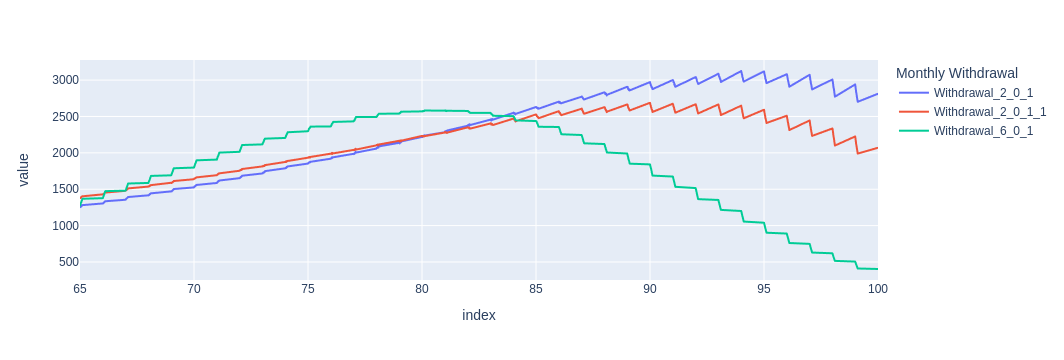

In [205]:
pd.options.plotting.backend = "plotly"

fig = monthly_withdrawal_median_6.iloc[:,range(1, len(monthly_withdrawal_median_6.columns))].plot()
fig.update_layout(legend=dict(title="Monthly Withdrawal")) 
#plotly.offline.plot(fig, filename='./annual_balance_general_6pct_stock.html')

In [206]:
monthly_bal_median_6 = prep_plot_m('balance_monthly_6pct.pkl', col_name = 'Balance')    

100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]


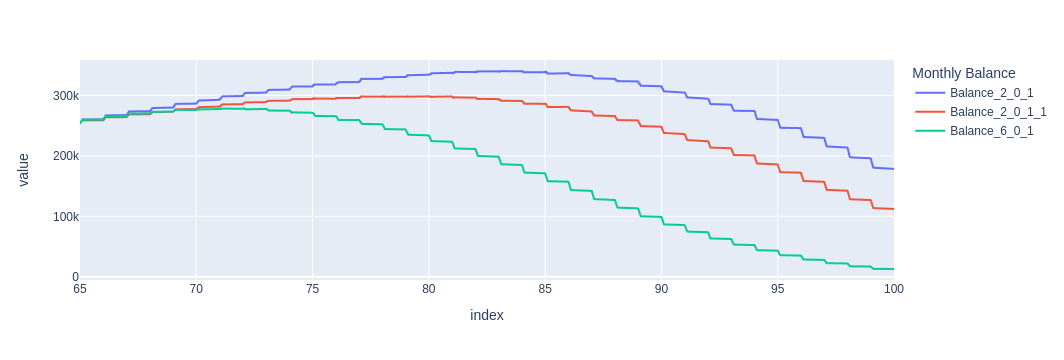

In [207]:
pd.options.plotting.backend = "plotly"

fig = monthly_bal_median_6.iloc[:,range(1, len(monthly_bal_median_6.columns))].plot()
fig.update_layout(legend=dict(title="Monthly Balance")) 
#plotly.offline.plot(fig, filename='./annual_balance_general_6pct_stock.html')

# Aggregate monthly rates to quarterly rates

In [208]:
def quarterlyRate(df):
    
    rate = []
    for i in range(5):      
        '''aggregate 5 rates'''
        rate_j = 1
        for j in list(df.iloc[:,i]):
            rate_j *= (1+j)
            #print(i, rate_j-1)
        
        rate.append(rate_j-1)
            
    return rate    

In [209]:
quarter_ret = {}
quarter_idx = list(range(0, len(sim_dict[0])-3, 3))
quarter_name = np.arange(65, 100, 0.25)

for i in tqdm(range(len(sim_dict))):
    sim_i = sim_dict[i]    
    
    ret_i = {} #quarterly returns
    for j in range(len(quarter_idx)):
        '''aggreate 3 monthly rates to 1 quarterly rate''' 
        ret_i[quarter_name[j]] = quarterlyRate(sim_i.iloc[quarter_idx[j]:(quarter_idx[j]+3)])
        
    quarter_ret[i] = ret_i

100%|█████████████████████████████████████| 10000/10000 [03:45<00:00, 44.38it/s]


In [211]:
pickle.dump(quarter_ret, open("month2quarter_ret_no_neg_dic.pkl", "wb"))

# read and transform quarterly RMD

In [255]:
rmd_quarter = pd.read_csv("rmd_quarter.csv")
rmd_quarter.head()

,Age,RMD
0,64.00,2.87%
1,64.25,2.87%
2,64.50,2.87%
3,64.75,2.87%
4,65.00,2.95%


In [256]:
rmd_quarter.RMD = [float(i.replace("%", ""))/400 for i in rmd_quarter.RMD]
rmd_quarter['RMD1'] = rmd_quarter.RMD*1.2

In [257]:
rmd_quarter.head()

,Age,RMD,RMD1
0,64.00,0.007175,0.00861
1,64.25,0.007175,0.00861
2,64.50,0.007175,0.00861
3,64.75,0.007175,0.00861
4,65.00,0.007375,0.00885


In [214]:
def method_2_quarterly(org_amt, rmd_quarter, start_age, end_age, stock_bond_sim_df, 
                       stock_weight, bond_weight, rmd1 = False):
    
    balance = [] 
    withdrawal = [] 
    org_left = org_amt

    rmd_sub = rmd_quarter.loc[(rmd_quarter.Age >= start_age) & (rmd_quarter.Age <= end_age)]
    rmd_sub.index = list(np.arange(start_age, end_age+0.1, 0.25))

    for i in np.arange(start_age, end_age, 0.25):
        
        if i == start_age:
            '''withdraw RMD/RMD1 % initial balance at the retirement moment''' 
            if rmd1 == True:
                withdrawal_ = org_left * (rmd_sub.RMD1[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = org_left * (rmd_sub.RMD[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            
            withdrawal.append(withdrawal_)
            
            org_left =  (org_left - withdrawal_)                   
            balance.append(org_left)              

        else:            
            '''for the following quarters, the left balance will grow with total bond and total stock 
            returns before next quarterly withdrawal'''            
            grow_left =  org_left * (1 + bond_weight * stock_bond_sim_df.Bond[i] \
                                   + stock_weight * stock_bond_sim_df.Stock[i])

            if rmd1 == True:
                withdrawal_ = grow_left * rmd_sub.RMD1[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                        + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = grow_left * rmd_sub.RMD[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])              
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ >= grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_)             

    return balance, withdrawal

In [219]:
def method_6_quarterly(org_amt, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate = 0.06):
    
    balance = [] 
    withdrawal = []
    org_left = org_amt

    for i in np.arange(start_age, end_age, 0.25):        
        if i == start_age:
            '''withdraw 6% initial balance at the retirement moment'''  
            withdrawal.append(org_left * withdrawal_rate)
            org_left =  org_left * (1-withdrawal_rate)  
            balance.append(org_left)

        elif i == start_age + 0.25:
            '''apply cumulated inflation rate on the 6% of the first year balance''' 

            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = stock_bond_sim_df.Inflation[i]             
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)     
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 
        else:            
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = (1+ stock_bond_sim_df.Inflation[i]) * (1+cum_inflation) - 1
            
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)  
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 

    return balance, withdrawal

In [220]:
def sim_10K_quarterly(org_amt, withdrawal_rate, start_age, end_age, 
            output_balance_path, output_withdrawal_path, sim_out = False):
    
    global joint_dist, q_r_sub, rmd_quarter
    
    '''1) withdrawal_rate is only for method 6
       2) Two types of rmd are used only for method 2 
    '''
    
    print(f'org_amt = {org_amt}; quarterly withdrawal rate = {withdrawal_rate}')
    print(f'Output pickle files are {output_balance_path} and {output_withdrawal_path}.\n')
    
    balance_2_0_1 = {}
    balance_2_0_1_1 = {}
    balance_6_0_1 = {}
    
    withdrawal_2_0_1 = {}
    withdrawal_2_0_1_1 = {}
    withdrawal_6_0_1 = {}    
    
    
    quarters = np.arange(start_age, end_age, 0.25)   

    for i in tqdm(range(10000)):
        
        '''simulate 10K of 141 autocorrelated quarterly data start with the last observed autocorrelaton data point'''
        
        stock_bond_sim_df = pd.DataFrame(quarter_ret[i]).T
        stock_bond_sim_df.columns = ['Stock', 'Income', 'Dividend', 'Inflation', 'Bond']
        stock_bond_sim_df.index = list(quarters)

        balance_2_0_1[i], withdrawal_2_0_1[i] = method_2_quarterly(org_amt,rmd_quarter,
                                        start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight)

        balance_2_0_1_1[i], withdrawal_2_0_1_1[i] = method_2_quarterly(org_amt,rmd_quarter,
                                        start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, rmd1 = True)

        balance_6_0_1[i], withdrawal_6_0_1[i] = method_6_quarterly(org_amt,start_age, 
                                        end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate =withdrawal_rate)

        
    pickle.dump((balance_2_0_1, balance_2_0_1_1, balance_6_0_1),                   
                open(f"{output_balance_path}", "wb")) 
   
    pickle.dump((withdrawal_2_0_1, withdrawal_2_0_1_1, withdrawal_6_0_1),
            open(f"{output_withdrawal_path}", "wb")) 

In [217]:
# set original retirmetn account balance, fixed quaterly withdrawl rate, bond/stock investiment ratio 
org_amt = 255200
quarterly_withdrawal_rate = 0.06/4

# #for all-stock portfolio
# bond_weight = 0
# stock_weight = 1

#for 60/40 split portfolio
bond_weight = 0.6
stock_weight = 0.4

# #for 70/30 split portfolio
# bond_weight = 0.7
# stock_weight = 0.3

In [120]:
q_r_sub = pickle.load(open("q_r_sub.pkl", "rb")) #for inversed dividend, inflation and income rates 

In [121]:
q_r_sub.head()

,Month_year,Stock-Total,Dividend,Bond-Total,Bond-Income,Inflation,Dividend_lag,Bond-Income_lag,Inflation_lag
184,1972-03-31,0.057512,0.005815,-0.005801,0.014660,0.007299,0.009519,0.014863,0.007353
185,1972-06-30,0.006667,0.007288,0.023170,0.015224,0.007246,0.005815,0.014660,0.007299
186,1972-09-30,0.039185,0.007205,0.016006,0.014743,0.009592,0.007288,0.015224,0.007246
187,1972-12-31,0.075637,0.007461,0.022586,0.014639,0.009501,0.007205,0.014743,0.009592
188,1973-03-31,-0.048867,0.006697,-0.022802,0.016119,0.018824,0.007461,0.014639,0.009501


In [258]:
#get 10K iteration outputs

sim_10K_quarterly(org_amt, quarterly_withdrawal_rate, 65, 100, 
                "./balance_monthly2quarterly_6pct.pkl", 
                "./withdrawal_monthly2quarterly_6pct.pkl")

org_amt = 255200; quarterly withdrawal rate = 0.015
Output pickle files are ./balance_monthly2quarterly_6pct.pkl and ./withdrawal_monthly2quarterly_6pct.pkl.



100%|█████████████████████████████████████| 10000/10000 [01:43<00:00, 96.98it/s]


# Export and merge month2quarter csv files

In [260]:
def merge_df_quarterly(input_path):
    
    '''1) output 60/40 investment portfolios
       2) merge balance and withdrawal side-by-side by age'''
    
    file_lst = os.listdir(input_path)
    file_lst.sort()
    file_lst = [i for i in file_lst if i != '.ipynb_checkpoints']
    print(f"The # of iutput files is {len(file_lst)}")
    #assert len(file_lst) == 72, "The input files # is more than 72."
    #assert len(file_lst) == 12, "The # of csv files is more than 12"
    
    file_len = int(len(file_lst)/2)
    
    output_file = 0
    for i in range(file_len):
        bal_i = pd.read_csv(f'{input_path}/{file_lst[i]}')
        wdrl_i = pd.read_csv(f'{input_path}/{file_lst[i+file_len]}')
    
        out_i = pd.concat([bal_i, wdrl_i], axis = 1) 
                          
        out_i.columns = renameCol(["balance" + str(i) for i in np.arange(65, 100, 0.25)]+ \
                        ["withdrawal" + str(i) for i in np.arange(65, 100, 0.25)])        
        
        out_i.to_csv(f"{input_path}/method_{file_lst[i]}", index = False)  
        output_file += 1
    print(f"The # of output files is {output_file}")

In [222]:
def export_csv_quarterly(input_bal_path, input_wdrl_path, output_csv_path):
    
    ''' all stock portfolio'''
    
    is_output_path = os.path.exists(output_csv_path)
    if not is_output_path:
        os.mkdir(output_csv_path)

    (bal_2_0_1, bal_2_0_1_1, bal_6_0_1) \
             = pickle.load(open(f"{input_bal_path}", "rb"))
    
    (wdrl_2_0_1, wdrl_2_0_1_1, wdrl_6_0_1) \
             = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
    export_lst = ['bal_2_0_1', 'wdrl_2_0_1', 
                  'bal_2_0_1_1', 'wdrl_2_0_1_1',
                  'bal_6_0_1', 'wdrl_6_0_1']
    
    for idx, _dict in enumerate((bal_2_0_1, wdrl_2_0_1,
                                 bal_2_0_1_1, wdrl_2_0_1_1,
                                 bal_6_0_1, wdrl_6_0_1)):        
        
        bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = list(np.arange(65, 100, 0.25)))
        bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False) 

In [259]:
export_csv_quarterly("./balance_monthly2quarterly_6pct.pkl", "./withdrawal_monthly2quarterly_6pct.pkl",
                     "./outputs_month2quarter_6pct/")

In [261]:
merge_df_quarterly("./outputs_month2quarter_6pct")

The # of iutput files is 6
The # of output files is 3


In [262]:
def prep_plot_q(pkl, col_name = 'method'):
    
    global quarter_name
    
    (method_2_0_1, method_2_0_1_1, method_6_0_1) = pickle.load(open(pkl, "rb"))   


    method_median = pd.Series(quarter_name, name = "Age")
    method_median.index = quarter_name
    for i in tqdm((method_2_0_1, method_2_0_1_1, method_6_0_1)):
        df_i = pd.DataFrame.from_dict(i, orient = "index", columns = quarter_name)
    
        method_median = pd.concat([method_median, df_i.median(axis =0)], axis = 1)
    
    method_median.columns = ['Age',f'{col_name}_2_0_1', f'{col_name}_2_0_1_1',                               
                             f'{col_name}_6_0_1']
    
    return method_median

In [263]:
quarterly_bal_median_6 = prep_plot_q('balance_monthly2quarterly_6pct.pkl', col_name = 'Balance')    

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


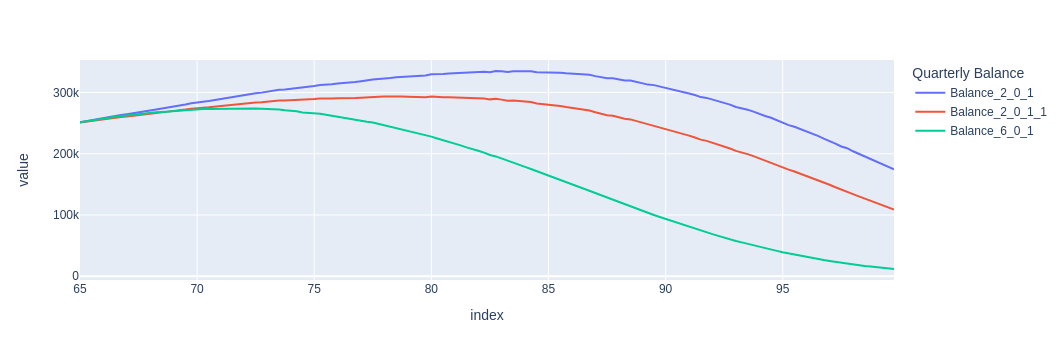

In [264]:
pd.options.plotting.backend = "plotly"

fig = quarterly_bal_median_6.iloc[:,range(1, len(quarterly_bal_median_6.columns))].plot()
fig.update_layout(legend=dict(title="Quarterly Balance")) 
#plotly.offline.plot(fig, filename='./annual_balance_general_6pct_stock.html')

# get annual returns from monthly returns

In [232]:
#sim_dict = pickle.load(open("sim_dict_fixed_mean.pkl", "rb"))

In [265]:
def annualRate(df):
    
    rate = []
    for i in range(5):      
        rate_j = 1
        for j in list(df.iloc[:,i]):
            rate_j *= (1+j)
        
        rate.append(rate_j-1)
            
    return rate    

In [266]:
try:
    sim_dict[0].shape
except:
    sim_dict = pickle.load(open("sim_dict_monthly.pkl", "rb"))

In [267]:
annual_ret = {}
for i in tqdm(range(len(sim_dict))):
    sim_i = sim_dict[i]    
    
    ret_i = {}
    for j in range(0, len(sim_i)-12, 12):
        ret_i[sim_i.index[j]] = annualRate(sim_i.iloc[j:(j+12)])
        
    annual_ret[i] = ret_i

100%|████████████████████████████████████| 10000/10000 [00:57<00:00, 175.38it/s]


In [268]:
pickle.dump(annual_ret, open("month2year_ret_no_neg_dic.pkl", "wb"))

In [48]:
#annual_ret = pickle.load(open("month2year_ret_no_neg_dic.pkl", "rb"))

In [269]:
rmd_year = pd.read_csv("rmd_annual.csv")
rmd_year['RMD1'] = rmd_year.RMD*1.2

In [270]:
rmd_year.head()

,Age,RMD,RMD1
0,62,0.0272,0.03264
1,63,0.0279,0.03348
2,64,0.0287,0.03444
3,65,0.0295,0.03540
4,66,0.0303,0.03636


In [271]:
def method_2_annual(org_amt, rmd_year, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, rmd1 = False):
    
    balance = [] 
    withdrawal = [] 
    org_left = org_amt

    rmd_sub = rmd_year.loc[(rmd_year.Age >= start_age) & (rmd_year.Age <= end_age)]
    rmd_sub.index = rmd_sub.Age

    for i in rmd_sub.index:
        
        if i == start_age:
            '''withdraw RMD % initial balance at the retirement moment''' 
            if rmd1 == True:
                withdrawal_ = org_left * (rmd_sub.RMD1[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = org_left * (rmd_sub.RMD[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
                
            withdrawal.append(withdrawal_)
            
            org_left =  (org_left - withdrawal_)                   
            balance.append(org_left)              

        else:            
            '''for the following years, the left balance will grow with total bond and total stock 
            returns before withdrawal next year'''            
            grow_left =  org_left * (1 + bond_weight * stock_bond_sim_df.Bond[i] \
                                   + stock_weight * stock_bond_sim_df.Stock[i])

            if rmd1 == True:
                withdrawal_ = grow_left * rmd_sub.RMD1[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])  
            else:
                withdrawal_ = grow_left * rmd_sub.RMD[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])  
            
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_)             

    return balance, withdrawal

In [272]:
def method_6_annual(org_amt, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate = 0.06):
    
    '''with X% annual withdrawal of previous year amount plus adjustement of inflation and investment growth'''  
    #global rmd
    
    balance = [] 
    withdrawal = []
    org_left = org_amt

    rmd_sub = rmd_year.loc[(rmd_year.Age >= start_age) & (rmd_year.Age <= end_age)]
    rmd_sub.index = rmd_sub.Age

    for i in rmd_sub.index:        
        if i == start_age:
            '''withdraw 6% initial balance at the retirement moment'''  
            withdrawal.append(org_left * withdrawal_rate)
            org_left =  org_left * (1 - withdrawal_rate)  
            balance.append(org_left)

        elif i == start_age + 1:
            '''apply cumulated inflation rate on the 6% of the first year balance''' 
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = stock_bond_sim_df.Inflation[i]             
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)               
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 
        else:            
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = (1+ stock_bond_sim_df.Inflation[i]) * (1+cum_inflation) - 1
            
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)  
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 

    return balance, withdrawal

In [273]:
def sim_10K_annual(annual_ret, org_amt, withdrawal_rate, start_age, end_age, 
                   output_balance_path, output_withdrawal_path):
    
    global rmd_year, stock_weight, bond_weight
    
#     is_output_balance = os.path.exists(output_balance_path)
#     if not is_output_balance:
#         os.mkdir(output_balance_path)
        
#     is_output_withdrawal = os.path.exists(output_withdrawal_path)
#     if not is_output_withdrawal:
#         os.mkdir(output_withdrawal_path)        
    
    print(f'org_amt = {org_amt}; withdrawal_rate = {withdrawal_rate}')
    print(f'Output pickle files is {output_balance_path} and {output_withdrawal_path}.')
    
    method_2_0_1 = {}
    method_2_0_1_1 = {}
    method_6_0_1 = {}
    
   
    withdrawal_2_0_1 = {}
    withdrawal_2_0_1_1 = {}
    withdrawal_6_0_1 = {}
    
   
    for i in tqdm(range(10000)):
        
        #stock_bond_sim_df = best_fit_df.sample((end_age-start_age +1), random_state = i)
        #stock_bond_sim_df.index = list(range(start_age, end_age+1))
        stock_bond_sim_df = pd.DataFrame(annual_ret[i]).T
        stock_bond_sim_df.columns = ['Stock', 'Income', 'Dividend', 'Inflation', 'Bond']
        stock_bond_sim_df.index = [int(i) for i in stock_bond_sim_df.index]

        method_2_0_1[i], withdrawal_2_0_1[i]= method_2_annual(org_amt, rmd_year, start_age, end_age, 
                                                              stock_bond_sim_df, stock_weight, bond_weight)
        method_2_0_1_1[i], withdrawal_2_0_1_1[i] = method_2_annual(org_amt,rmd_year, start_age, end_age, 
                                                              stock_bond_sim_df, stock_weight, bond_weight, rmd1 = True)
        method_6_0_1[i], withdrawal_6_0_1[i] = method_6_annual(org_amt,start_age, end_age, stock_bond_sim_df,
                                                              stock_weight, bond_weight, withdrawal_rate = withdrawal_rate)

    
    pickle.dump((method_2_0_1, method_2_0_1_1, method_6_0_1),   
                open(f"{output_balance_path}", "wb")) 
    pickle.dump((withdrawal_2_0_1, withdrawal_2_0_1_1, withdrawal_6_0_1),
                 open(f"{output_withdrawal_path}", "wb")) 


In [274]:
org_amt = 255200
withdrawal_rate = 0.06
bond_weight = 0.6
stock_weight = 0.4

In [275]:
%%time

sim_10K_annual(annual_ret, 255200, 0.06, 65, 99, "./month2annual_balance_6pct.pkl", 
               "./month2annual_withdrawal_6pct.pkl")

org_amt = 255200; withdrawal_rate = 0.06
Output pickle files is ./month2annual_balance_6pct.pkl and ./month2annual_withdrawal_6pct.pkl.


100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 286.15it/s]


CPU times: user 38.4 s, sys: 534 ms, total: 38.9 s
Wall time: 39.2 s


In [276]:
def export_csv_annual(input_bal_path, input_wdrl_path, output_csv_path):
    
    is_output_path = os.path.exists(output_csv_path)
    if not is_output_path:
        os.mkdir(output_csv_path)

    (bal_2_0_1, bal_2_0_1_1, bal_6_0_1) \
             = pickle.load(open(f"{input_bal_path}", "rb"))
    
    (wdrl_2_0_1, wdrl_2_0_1_1, wdrl_6_0_1) \
             = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
    export_lst = ['bal_2_0_1', 'wdrl_2_0_1', 'bal_2_0_1_1', 'wdrl_2_0_1_1', 'bal_6_0_1', 'wdrl_6_0_1']
    
    for idx, _dict in enumerate((bal_2_0_1, wdrl_2_0_1, bal_2_0_1_1, 
                                 wdrl_2_0_1_1, bal_6_0_1, wdrl_6_0_1)):        
        
        bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = list(range(65,100)))
        bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False)  

In [277]:
export_csv_annual("./month2annual_balance_6pct.pkl", 
                  "./month2annual_withdrawal_6pct.pkl",
                  "./outputs_monthly2annual_6pct/")

In [278]:
def merge_df_annual(input_path):
    
    '''merge balance and withdrawal side-by-side by age'''
    # # Create a new directory because it does not exist
    # is_output_path = os.path.exists(output_path)
    # if not is_output_path:
    #     os.mkdir(output_path)
    
    file_lst = os.listdir(input_path)
    file_lst.sort()
    file_lst = [i for i in file_lst if ".csv" in i]
    #print(len(file_lst))
    #assert len(file_lst) == 72, "The input files # is more than 72."
    
    file_len = int(len(file_lst)/2)
    
    for i in range(file_len):
        bal_i = pd.read_csv(f'{input_path}/{file_lst[i]}')
        wdrl_i = pd.read_csv(f'{input_path}/{file_lst[i+file_len]}')
    
        out_i = pd.concat([bal_i, wdrl_i], axis = 1)        
        
        out_i.to_csv(f"{input_path}/method_{file_lst[i]}", index = False)   

In [284]:
merge_df_annual("./outputs_monthly2annual_6pct/")

In [280]:
years = pd.DataFrame(annual_ret[i]).T.index

In [281]:
def prep_plot_y(pkl, col_name = 'method'):
    
    (method_2_0_1, method_2_0_1_1, method_6_0_1) = pickle.load(open(pkl, "rb"))   


    method_median = pd.Series(years, name = "Age")
    method_median.index = years
    for i in tqdm((method_2_0_1, method_2_0_1_1, method_6_0_1)):
        df_i = pd.DataFrame.from_dict(i, orient = "index", columns = years)
    
        method_median = pd.concat([method_median, df_i.median(axis =0)], axis = 1)
    
    method_median.columns = ['Age',f'{col_name}_2_0_1', f'{col_name}_2_0_1_1',                               
                             f'{col_name}_6_0_1']
    
    return method_median

In [282]:
m2y_bal_median_6_stock = prep_plot_y('month2annual_balance_6pct.pkl', col_name = 'Balance')   

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 19.38it/s]


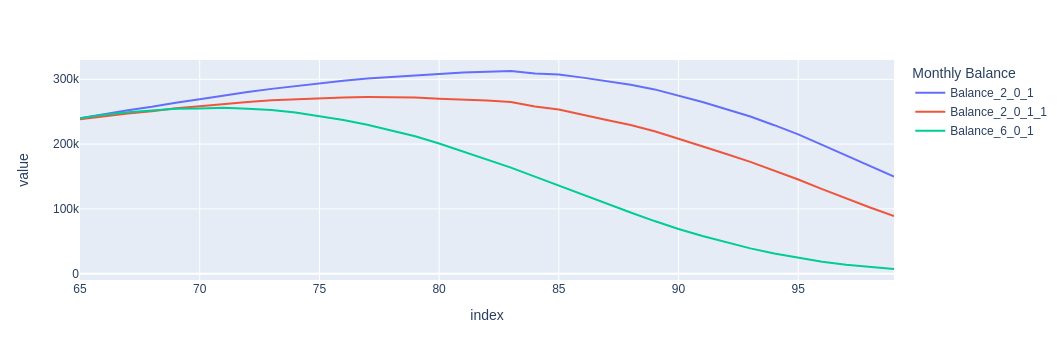

In [283]:
pd.options.plotting.backend = "plotly"

fig = m2y_bal_median_6_stock.iloc[:,range(1, len(m2y_bal_median_6_stock.columns))].plot()
fig.update_layout(legend=dict(title="Monthly Balance")) 
#plotly.offline.plot(fig, filename='./annual_balance_general_6pct_stock.html')